# Ερώτηση 3 (Clustering)

## Loading data

In [131]:
import pandas as pd
import numpy as np
import json
import time 

dataset_path = '../yelp-dataset/' # Change this path to match your local dataset folder path
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/'
# path = leftK_path

business_filename = 'yelp_academic_dataset_business.json'
review_filename = 'yelp_academic_dataset_review.json'

# Reading business file
start = time.time()

list_business = []
categories_order = ['Beauty & Spas', 'Shopping', 'Bars']

with open(dataset_path + business_filename, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] >= 10 and \
            json_dict['categories'] is not None and \
            any(word in json_dict['categories'] for word in categories_order):
                # The following line makes sure that every buisness categoy is
                # set to one of the categories_order list in that specific order.
                temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                list_business.append([json_dict['business_id'], temp_cat])

stop = time.time()
print("Read file in {:.3f} seconds".format(stop-start))

df_buisness = pd.DataFrame(list_business, columns=['business_id', 'categories'])
display(df_buisness.head())
print('{} businesses in df_buisness'.format(df_buisness['business_id'].size))

Read file in 2.287 seconds


,business_id,categories
0,cicPsia8Wj-DNRkmLbD_xg,Bars
1,xVXyrTWbG8U3szze-aA7eg,Bars
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas
3,TKKX9bllRBMzp0NYr441PQ,Bars
4,C9keC4mWuXdl2mYFHZXudQ,Shopping


3502 businesses in df_buisness


In [132]:
# Extracting unique buisness ids
np_businesses = np.array(list_business)
np_businesses_ids = np_businesses[:,0]
np_businesses_ids

array(['cicPsia8Wj-DNRkmLbD_xg', 'xVXyrTWbG8U3szze-aA7eg',
       'e-tRKAC-q40SqQfAOwYa-A', ..., 'AqpB2IoLkUupDCuH-hmVdg',
       'thzyiQZb16zD8wMliaEfRQ', '0hudPyuCBlKg79OwKBw-eQ'], dtype='<U22')

In [133]:
def find_buisness_index(business_id):
    index = np.where(np_businesses_ids == business_id)[0]
    return index

# Reading reveiws file
start = time.time()
business_reviews = [[] for i in range(int(len(np_businesses_ids)))]

with open(dataset_path + review_filename, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = find_buisness_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_reviews[index[0]]) == 0:
               business_reviews[index[0]] = json_dict['text']
            else:
               business_reviews[index[0]] += json_dict['text']

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 5.006 mins


Reading time: about 5 mins

In [134]:
df_business_reviews = pd.DataFrame(business_reviews, columns=['reviews as a single string for each buisness'])
df_business_reviews

,reviews as a single string for each buisness
0,"Consistently good, as the Keg tends to be.\n\n..."
1,I would give zero stars. I came here with a gr...
2,A blissful experience! I highly recommended th...
3,Mi'Hito is a new poke/sushi burrito chain that...
4,If you're a boy and you want to wear some hot ...
...,...
3497,This used to be my favourite place. It was alw...
3498,Very welcoming place. Great setup and super fr...
3499,I can't beleive I am saying this... but I left...
3500,I am really disappointed with this place. I t...


## TF-IDF

In [241]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

# Allowing words that are alpharithmetics more than 2 chars, excluding
# common words that exist in more than max_df of docs and rare words that
# exist in less than min_df of docs.
tfidf = TfidfVectorizer(min_df=0.25,
                        max_df=0.85,
                        max_features=8000,
                        token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b',
                        lowercase=True,
                        stop_words=stop_words)

document_term_matrix = tfidf.fit_transform(business_reviews)

In [242]:
import random 
samples_num = 30
print('Sample of words included in the features:\n{}\n\n'.format(random.sample(tfidf.get_feature_names(), samples_num)))
print('Sample of effective stop words list.:\n{}'.format(random.sample(tfidf.get_stop_words(), samples_num)))

Sample of words included in the features:
['type', 'water', 'fairly', 'longer', 'town', 'groups', 'll', 'appointment', 'local', 'talking', 'appreciated', 'served', 'dollars', 'money', 'told', 'morning', 'middle', 'original', 'smaller', 'actually', 'live', 'difference', 'nearby', 'giving', 'near', 'working', 'mind', 'overly', 'green', 'plus']


Sample of effective stop words list.:
['upped', 'albeit', 'nor', 'aside', 'me', 'somebody', 'forer', 'fill', 'cest', 'sincere', 'ever', 'himself', 'whatsoeverer', 'onto', 'outed', 'described', 'h', 'put', 'differenter', 'however', 'amount', 'unless', 'failing', 'herself', 'ourselves', 'yourself', 'due', 'hence', 'immediate', 'plaintiff']


## Kmeans

In [327]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# True values table: Μatching categories to numbers
true_labels = np_businesses[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('Bars: {}\nBeauty & Spas: {}\nShopping: {}\nSum: {}'.format(n0, n1, n2, n0+n1+n2))

def Kmeans_winfo(n_clusters, true_labels, data):
    kmeans = KMeans(init='k-means++', 
                    n_clusters=n_clusters, 
                    n_init=25, 
                    max_iter=600,  
                    random_state=42)

    predictions = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    error = kmeans.inertia_
    cfm = confusion_matrix(true_labels, predictions) 

    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]
    # mapped_kmeans_labels = np.empty_like(predictions)
    # for k in np.unique(predictions):
    #     match_nums = [np.sum((predictions==k)*(true_labels==t)) for t in np.unique(true_labels)]
    #     mapped_kmeans_labels[predictions==k] = np.unique(true_labels)[np.argmax(match_nums)]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall = recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    
    # Display info
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title('Cluster centroids')
    for centroids in kmeans.cluster_centers_:
        plt.plot(centroids[0], centroids[1], marker='x')

    axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.subplot(1, 3, 2)
    plt.title('Confusion Matrix')
    plt.axis('square')
    sns.heatmap(cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 3, 3)
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

    return mapped_kmeans_labels, kmeans.cluster_centers_


def scatter_kmeans(data, centroids, predictions):
    d = {0:'r', 1:'g', 2:'b'}
    str_true_labels = [d[value] for value in true_labels] 
    reduced_data = PCA(n_components=2).fit_transform(data_for_agglo)
    centers_2d = PCA(n_components=2).fit_transform(centroids)
    plt.title('PCA Cluster Plot')
    # for index, instance in enumerate(reduced_data):
    #     # print instance, index, labels[index]
    #     pca_comp_1, pca_comp_2 = reduced_data[index]
    #     color = str_true_labels[index]
    #     ax.scatter(pca_comp_1, pca_comp_2, c=color, cmap='vivids')
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=predictions ,s=50, cmap='viridis')
    plt.scatter(centers_2d[:,0], centers_2d[:,1], 
                marker='o', s=200, c='black', alpha=0.5)
    plt.show()

Bars: 1769
Beauty & Spas: 826
Shopping: 907
Sum: 3502


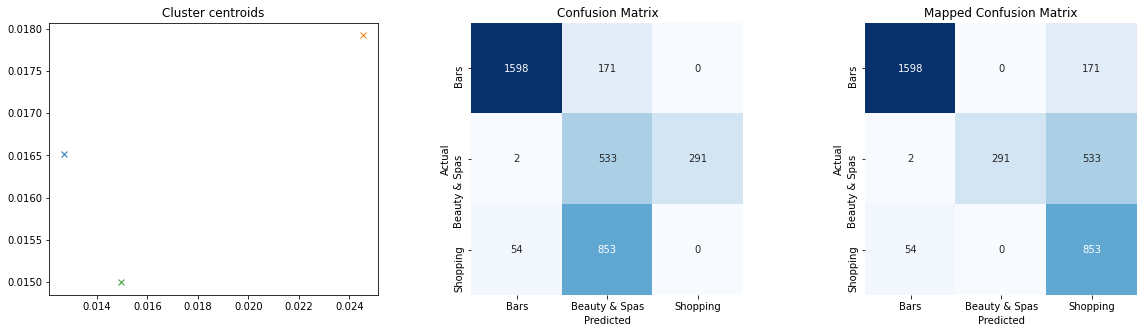

Precision : [0.96614268 1.         0.54784843]
Weighted precision: 0.866
Recall : [0.90333522 0.35230024 0.94046307]
Weighted recall: 0.866
Score : 0.154


In [328]:
labels_c3, centers_c3 = Kmeans_winfo(3, true_labels, document_term_matrix)

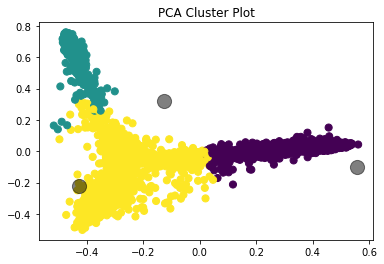

In [330]:
scatter_kmeans(document_term_matrix.todense(), centers_c3, labels_c3)

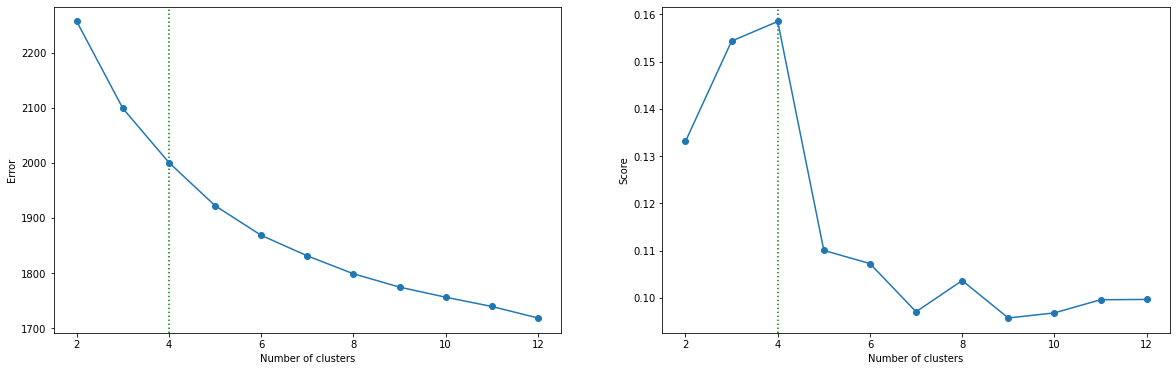

Best number of clusters 4, with silouhette coefficient of 0.1585.


In [246]:
n_clusters = 12
max_score = 0
error = np.zeros(n_clusters+1)
score = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):     
    start = time.time()
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=25, max_iter=600,  random_state=42)
    preds = kmeans.fit_predict(document_term_matrix)
    error[k] = kmeans.inertia_
    score[k] = silhouette_score(document_term_matrix, preds)
    if (score[k] > max_score):
        f_clasters = k 
        max_score = score[k]
    stop = time.time()
    #print('Clusters {} finished, time {:.2f}s, score {:.2f}'.format(k, stop-start, score[k]))

# Displaying results
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.axvline(x=f_clasters, color='g', linestyle=':')
plt.plot(np.array(range(2,n_clusters+1)), error[2:], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.axvline(x=f_clasters, color='g', linestyle=':')
plt.plot(np.array(range(2,n_clusters+1)), score[2:], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

plt.show()

print('Best number of clusters {}, with silouhette coefficient of {:.4f}.'.format(f_clasters, max_score))

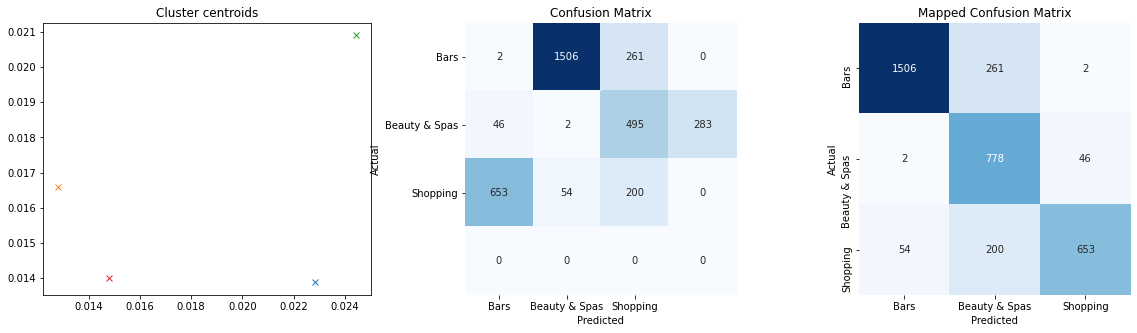

Precision : [0.96414853 0.62792575 0.93152639]
Weighted precision: 0.876
Recall : [0.85132843 0.94188862 0.7199559 ]
Weighted recall: 0.876
Score : 0.140


In [259]:
labels_c4, centers_c4 = Kmeans_winfo(f_clasters, true_labels, document_term_matrix)

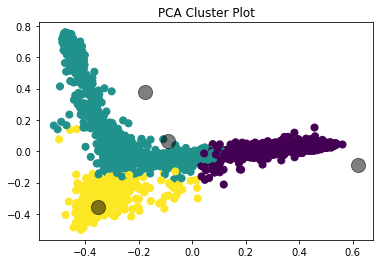

In [331]:
scatter_kmeans(document_term_matrix.todense(), centers_c4, labels_c4)

In [261]:
def display_agglomerative_info(true_labels, predictions, data):
    cfm = confusion_matrix(true_labels, predictions) 

    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall =recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    # Display info
    plt.figure(figsize=(15, 5))
    x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=x_axis_labels)
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

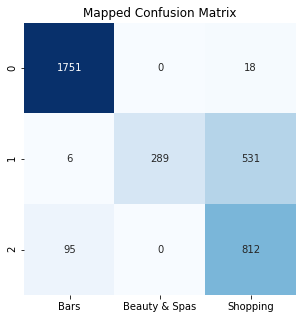

Precision : [0.94546436 1.         0.59662013]
Weighted precision: 0.868
Recall : [0.98982476 0.34987893 0.8952591 ]
Weighted recall: 0.868
Score : 0.155


In [262]:
from sklearn.cluster import AgglomerativeClustering

data_for_agglo = document_term_matrix.todense()
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

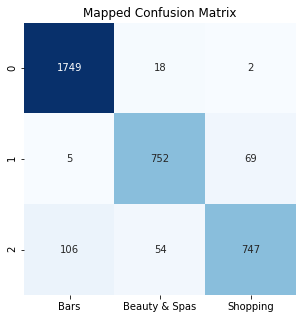

Precision : [0.94032258 0.91262136 0.91320293]
Weighted precision: 0.927
Recall : [0.98869418 0.91041162 0.82359427]
Weighted recall: 0.927
Score : 0.146


In [263]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

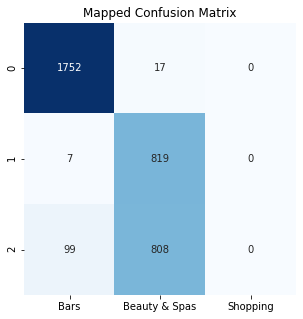

Precision : [0.94294941 0.49817518 0.        ]
Weighted precision: 0.594
Recall : [0.99039005 0.99152542 0.        ]
Weighted recall: 0.594
Score : 0.133


In [264]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

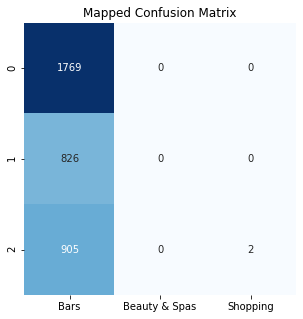

Precision : [0.50542857 0.         1.        ]
Weighted precision: 0.514
Recall : [1.         0.         0.00220507]
Weighted recall: 0.514
Score : 0.057


In [265]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

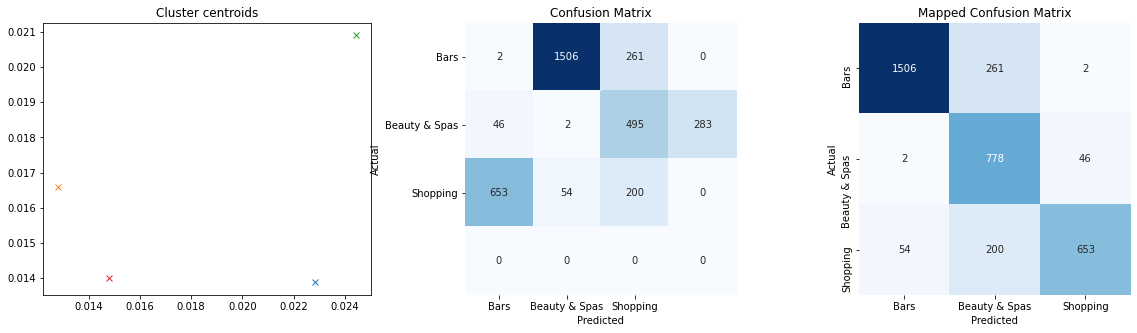

Precision : [0.96414853 0.62792575 0.93152639]
Weighted precision: 0.876
Recall : [0.85132843 0.94188862 0.7199559 ]
Weighted recall: 0.876
Score : 0.140


array([[0.02282398, 0.01387414, 0.00426596, ..., 0.0076923 , 0.01075354,
        0.00111038],
       [0.0128046 , 0.01659599, 0.00778532, ..., 0.00517156, 0.00683909,
        0.01576545],
       [0.02443862, 0.02090129, 0.01169333, ..., 0.00953667, 0.00964414,
        0.00318246],
       [0.01479532, 0.01398675, 0.00645581, ..., 0.00691881, 0.00659561,
        0.00029046]])

In [266]:
labels, centroids = Kmeans_winfo(4, true_labels, document_term_matrix)
centroids

In [267]:
sampled_buisnesses = np.random.choice(data_for_agglo.shape[0], 10, replace=False)
sampled_labels  = [value for index, value in enumerate(labels) if index in sampled_buisnesses]

In [268]:
sampled_buisnesses


array([1303, 1757, 2397, 2099, 1485, 2583,  968, 3175, 3112, 1326])

In [269]:

str_sampled_labels = [d[value] for value in sampled_labels]
str_sampled_labels

['b', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'b', 'b']

In [270]:
sampled_data = [value for index, value in enumerate(data_for_agglo) if index in sampled_buisnesses]

In [271]:
sampled_data = np.array(sampled_data)

In [311]:
#df = pd.DataFrame(document_term_matrix.todense()).groupby(clusters).mean()

#get_top_keywords(document_term_matrix, labels_c4, tfidf.get_feature_names(), 10)   

df = pd.DataFrame(document_term_matrix.todense()).apply(list)
df

,0,1,2,3,4,5,6,7,8,9,...,795,796,797,798,799,800,801,802,803,804
0,0.004913,0.045554,0.021505,0.000000,0.021227,0.000000,0.013413,0.000000,0.007503,0.000000,...,0.000000,0.006763,0.021571,0.026307,0.051866,0.005894,0.005414,0.030063,0.014389,0.021981
1,0.000000,0.000000,0.000000,0.000000,0.020139,0.029503,0.015907,0.000000,0.017796,0.000000,...,0.000000,0.000000,0.076747,0.000000,0.000000,0.000000,0.051364,0.017827,0.017065,0.017378
2,0.000000,0.000000,0.000000,0.000000,0.027650,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035123,0.000000,0.000000,0.000000,0.035259,0.048949,0.000000,0.000000
3,0.009433,0.000000,0.000000,0.013526,0.016302,0.071644,0.025753,0.000000,0.000000,0.000000,...,0.013402,0.000000,0.020708,0.000000,0.000000,0.000000,0.000000,0.014430,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.122912,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050524,0.000000,0.000000,0.038082,0.068255,0.000000,0.039185,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,0.013082,0.040431,0.000000,0.000000,0.011304,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.015694,0.000000,0.000000,0.019156,0.000000
3498,0.021496,0.022144,0.000000,0.000000,0.018574,0.000000,0.029341,0.031195,0.000000,0.059891,...,0.000000,0.000000,0.023594,0.000000,0.000000,0.077359,0.023685,0.000000,0.031476,0.000000
3499,0.000000,0.000000,0.000000,0.000000,0.029192,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047998,0.000000,0.000000,0.036178,0.000000,0.040528,0.000000,0.051679,0.000000,0.000000
3500,0.000000,0.041217,0.000000,0.008195,0.024693,0.000000,0.000000,0.008295,0.034912,0.000000,...,0.016241,0.000000,0.025094,0.000000,0.065821,0.020570,0.012596,0.008743,0.008370,0.051140


[0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
